In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
root='C:\\Users\\MUH0351\\Instacart Market Basket Analysis\\'
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from scipy import stats
from imblearn.over_sampling import SMOTE

In [2]:
df_final = pd.read_pickle(root + 'train_df.pkl')
df_final.head()

,user_id,product_id,user_product_orders,user_product_reorders,user_product_reorder_ratio,user_product_add_to_cart_ratio,user_product_dow_ratio,user_product_hour_ratio,avg_days_since_last_purchase,reorder_in_third_last_order,reorder_in_second_last_order,reorder_in_last_order,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,10.0,9.0,0.900000,1.400000,2.500000,10.300000,17.600000,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
1,1,10258,9.0,8.0,0.888889,3.333333,2.555556,10.555556,19.555556,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0
2,1,10326,1.0,0.0,0.000000,5.000000,4.000000,15.000000,28.000000,0.0,0.0,0.0,11.0,4.0,8.0,14.0,0.0
3,1,12427,10.0,9.0,0.900000,3.300000,2.500000,10.300000,17.600000,1.0,1.0,1.0,11.0,4.0,8.0,14.0,0.0
4,1,13032,3.0,2.0,0.666667,6.333333,2.666667,8.000000,21.666667,1.0,0.0,0.0,11.0,4.0,8.0,14.0,1.0


In [3]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [4]:
df = reduce_memory(df_final)

Memory usage of properties dataframe is : 1163.8175811767578  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  371.7750606536865  MB
This is  31.944444444444443 % of the initial size


In [5]:
df.columns

Index(['user_id', 'product_id', 'user_product_orders', 'user_product_reorders',
       'user_product_reorder_ratio', 'user_product_add_to_cart_ratio',
       'user_product_dow_ratio', 'user_product_hour_ratio',
       'avg_days_since_last_purchase', 'reorder_in_third_last_order',
       'reorder_in_second_last_order', 'reorder_in_last_order', 'order_number',
       'order_dow', 'order_hour_of_day', 'days_since_prior_order',
       'reordered'],
      dtype='object')

In [6]:
df.drop(['user_id','product_id'], axis=1, inplace=True)

In [7]:
df.shape

(8474661, 15)

In [8]:
sum(df['reordered'])/len(df['reordered'])

0.09780025419305857

In [9]:
X=df[df.columns.drop(['reordered'])]
y=df['reordered']

In [10]:
X.shape

(8474661, 14)

In [11]:
y.shape

(8474661,)

In [12]:
y.value_counts()

0.0    7645837
1.0     828824
Name: reordered, dtype: int64

As the target class is significantly imbalance and misclassified, therefore to avoid the biased model, SMOTE will implemented to deal with imbalance data.

In [13]:
sm = SMOTE(sampling_strategy= 'auto',
  k_neighbors=5,
  n_jobs=4)
X_sm, y_sm= sm.fit_resample(X,y)

C:\Users\MUH0351\Anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [14]:
y_sm.value_counts()

1.0    7645837
0.0    7645837
Name: reordered, dtype: int64

In [15]:
X_train,X_test, y_train,y_test= train_test_split(X_sm,y_sm, stratify=y_sm, test_size=0.25)

In [16]:
y_train.value_counts()

0.0    5734378
1.0    5734377
Name: reordered, dtype: int64

In [17]:
y_test.value_counts()

1.0    1911460
0.0    1911459
Name: reordered, dtype: int64

In [18]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11468755, 14) (11468755,)
(3822919, 14) (3822919,)


In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
xgb_params = {
#     "objective"        :"reg:logistic",
#     "eval_metric"      :"logloss",
    "n_estimators"     : stats.randint(5,100),
    "max_depth"        : stats.randint(1,10),
    "min_child_weight" :stats.randint(1,10),
    "gamma"            : stats.uniform(0.01, 1),
    "subsample"        : stats.uniform(0.01, 1),
    "colsample_bytree" : stats.uniform(0.01, 1),
    "alpha"            : stats.uniform(0.01, 1),
    "scale_pos_weight" : stats.randint(1,10),
    "lambda"           : stats.randint(1, 10)
 }


In [21]:
random_search = RandomizedSearchCV(xgb.XGBClassifier(),
                           xgb_params,
                           scoring='roc_auc',
                           n_iter=60,
                           cv=3,
                           refit=True,
                           n_jobs=4
                      )

In [22]:
random_search.fit(X_train,y_train)

[16:00:04] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


RandomizedSearchCV(cv=3, estimator=XGBClassifier(), n_iter=60, n_jobs=4,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000246F04FA130>,
                                        'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000246F050B850>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen obje...
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000246F04FFF70>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000246F04FF130>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000246F050BBE0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuou

In [23]:
random_search.best_params_

{'alpha': 0.022384716282796473,
 'colsample_bytree': 0.503866321112233,
 'gamma': 0.39223949884553133,
 'lambda': 6,
 'max_depth': 9,
 'min_child_weight': 2,
 'n_estimators': 86,
 'scale_pos_weight': 1,
 'subsample': 0.018771654273856957}

In [24]:
xgb_params =  {
     "objective"        :"reg:logistic",
     "eval_metric"      :"logloss",
    'alpha': 0.022384716282796473,
     'colsample_bytree': 0.503866321112233,
     'gamma': 0.39223949884553133,
     'lambda': 6,
     'max_depth': 9,
     'min_child_weight': 2,
     'n_estimators': 86,
     'scale_pos_weight': 1,
     'subsample': 0.018771654273856957
    }

In [25]:
eval_list=[(dtrain,'train')]
model_train = xgb.train(
    params=xgb_params, 
    dtrain=dtrain, 
    evals= eval_list,
    num_boost_round=80,
    verbose_eval=10,
    early_stopping_rounds=20
)


[21:17:46] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	train-logloss:0.587055
Will train until train-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.302772
[20]	train-logloss:0.250345
[30]	train-logloss:0.225362
[40]	train-logloss:0.207019
[50]	train-logloss:0.199261
[60]	train-logloss:0.194424
[70]	train-logloss:0.190213
[79]	train-logloss:0.187853


In [26]:
probability=model_train.predict(dtest)

In [27]:
predictions=[1 if x>0.5 else 0 for x in probability]

Classification Report: 
                precision    recall  f1-score   support

         0.0       0.90      0.97      0.93   1911459
         1.0       0.97      0.89      0.93   1911460

    accuracy                           0.93   3822919
   macro avg       0.93      0.93      0.93   3822919
weighted avg       0.93      0.93      0.93   3822919

Accuracy rate:
 0.9295781574236859


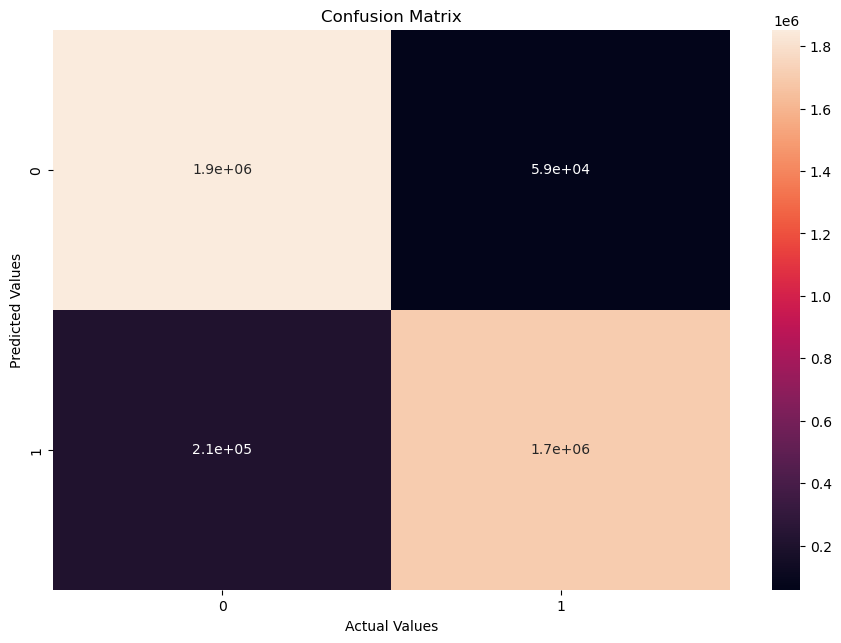

F1 Score:  0.9266758960595686


In [28]:
print('Classification Report: \n ', classification_report(y_test, predictions))
print('Accuracy rate:\n', accuracy_score(y_test,predictions))


#confusion matrix
con_mat = confusion_matrix(y_test,predictions)
plt.figure(figsize=(24,16))
plt.subplot(222)
sns.heatmap(con_mat, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

#f1 score
f1_scr = f1_score(y_test, predictions)
print('F1 Score: ',f1_scr)


Area under curve :  0.9721160254563206 



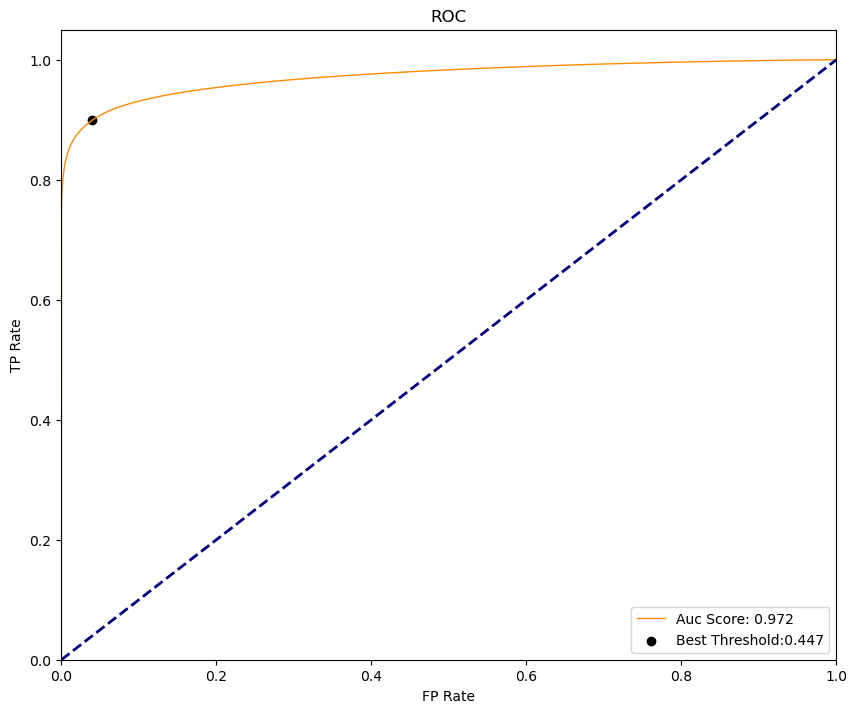

In [30]:
#roc_auc_score
model_roc_auc = roc_auc_score(y_test,probability) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probability)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)
plt.figure(figsize=(22,18))
plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc Score: %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()


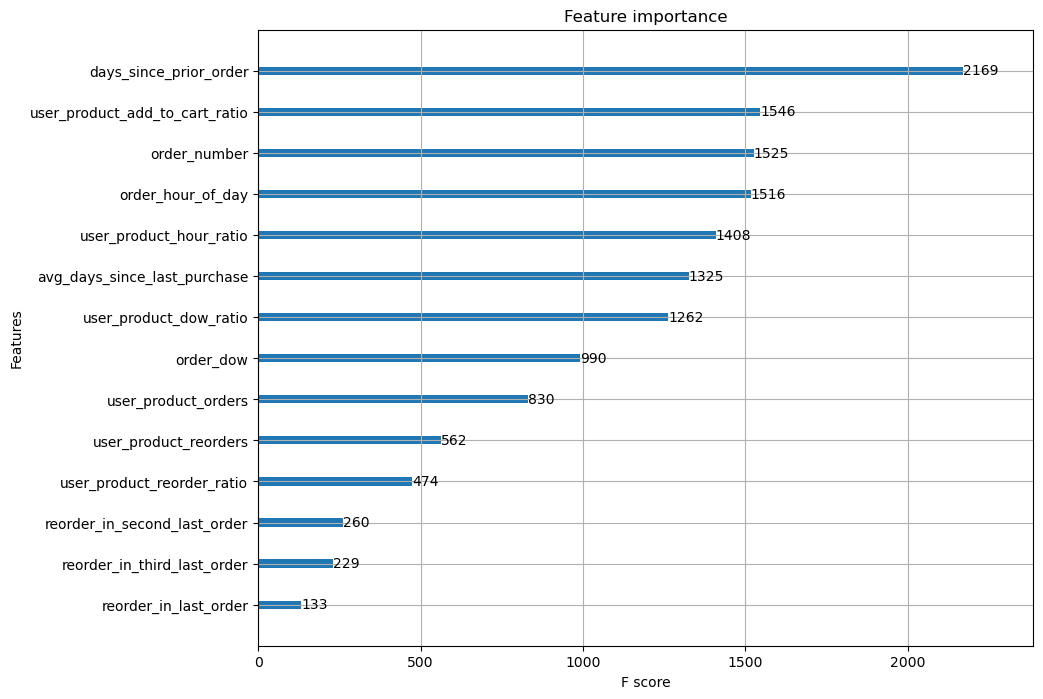

In [31]:
plt.figure(figsize=(10, 8))
xgb.plot_importance(model_train, ax=plt.gca())
plt.show()